In [32]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from scipy.optimize import curve_fit

# Introduction

This notebook aims to model my own estradiol serum concentration from blood test results over the past few months.

We start with a 3-compartment linear pharmacokinetic model, then derive the theoretical serum estradiol concentration from the model for completeness (as well as for the learning experience in solving differential equations using Laplace transform).

[An Informal Meta-Analysis of Estradiol Curves with Injectable Estradiol Preparations](https://transfemscience.org/articles/injectable-e2-meta-analysis/) by Aly from Transfeminine Science included a model of serum estradiol for a given injectable estradiol regimen. However, I'm currently using various strengths of estradiol patches (a mixture of Estradot and Mylan Estradiol TDP).

The aforementioned article from Transfeminine Science uses compartment models obtained from the literature. Here, we will also use a compartment model, in particular the 3-compartment model.

# Three-Compartment Model

The compartment models have the form of the [Bateman equation](https://en.wikipedia.org/wiki/Bateman_equation) that's used in physics to describe nuclear decay rate by modeling the transition rates from one species to another. It's also an example of a classical [master equation](https://en.wikipedia.org/wiki/Master_equation) where we only have a diagonal matrix that describes the "transition" probabilities (a weird word choice here due to my first encounter with master equations come from quantum optics).

The dynamics of a simple 3-compartment model is given by a system of linear differential equations ([Sheiner et al., 1979](https://doi.org/10.1002/cpt1979253358))

\begin{align*}
    \dot D(t) &= -k_1 D(t) \\
    \dot A_{\rm eff}(t) &= k_1 D(t) - k_2 A_{\rm eff}(t) \\
    \dot E_2(t) &= k_2 A_{\rm eff}(t) - k_3 E_2(t),
\end{align*}

where $\dot{}$ denotes time derivatives, $D(t)$ is the estradiol concentration within the depot (e.g., the patch sites at $200\rm~\mu g/day$), $A_{\rm eff}$ is the (hypothetical) amount of estradiol in the effect compartment, and $E_2(t)$ is the observed serum estradiol concentration at time $t$ (the level compartment).

To solve the above system, we use Laplace transform to first annihilate the time derivatives and turn the system into a system of algebraic equations. The Laplace transform of first-order derivative $\dot f(t)$ of the function $f(t)$ is given by $$\mathcal{L}[\dot f(t)]=s\hat f(s)-f(t_0),$$ and Laplace transform is linear.

Thus, our system of differential equations in the Laplace space $s$ is

\begin{align*}
    s\hat D(s)-D(t_0) &= -k_1\hat D(s) \\
    s\hat A_{\rm eff}(s)-A_{\rm eff}(t_0) &= k_1\hat D(s)-k_2\hat A_{\rm eff}(s)\\
    s\hat E_2(s)-E_2(t_0) &= k_2\hat A_{\rm eff}(s) - k_3\hat E_2(s).
\end{align*}

After grouping like terms, we can rewrite the above system in matrix notation $$\begin{bmatrix}s+k_1 & 0 & 0 \\ -k_1 & s+k_2 & 0 \\ 0 & -k_2 & s+k_3\end{bmatrix}\begin{bmatrix}\hat D(s) \\ \hat A_{\rm eff}(s) \\ \hat E_2(s)\end{bmatrix}=\begin{bmatrix}D(t_0) \\ A_{\rm eff}(t_0) \\ E_2(t_0) \end{bmatrix}.$$

Next, to solve this algebraic system in Laplace space $s$, we use [Cramer's rule](https://en.wikipedia.org/wiki/Cramer's_rule), giving us

\begin{align*}
    \hat D(s)&=\frac{\operatorname{det}\left|\begin{matrix}D(t_0) & 0 & 0 \\ A_{\rm eff}(t_0) & s+k_2 & 0 \\ E_2(t_0) & -k_2 & s+k_3\end{matrix}\right|}{\operatorname{det}\left|\begin{matrix}s+k_1 & 0 & 0 \\ -k_1 & s+k_2 & 0 \\ 0 & -k_2 & s+k_3\end{matrix}\right|}=\frac{D(t_0)}{s+k_1} \\ \\
    \hat A_{\rm eff} &=\frac{\operatorname{det}\left|\begin{matrix}s+k_1 & D(t_0) & 0 \\ -k_1 & A_{\rm eff}(t_0) & 0 \\ 0 & E_2(t_0) & s+k_3\end{matrix}\right|}{\operatorname{det}\left|\begin{matrix}s+k_1 & 0 & 0 \\ -k_1 & s+k_2 & 0 \\ 0 & -k_2 & s+k_3\end{matrix}\right|}=\frac{k_1D(t_0)}{(s+k_1)(s+k_2)}+\frac{A_{\rm eff}(t_0)}{s+k_2} \\ \\
    \hat E_2(s)&=\frac{\operatorname{det}\left|\begin{matrix}s+k_1 & 0 & D(t_0) \\ -k_1 & s+k_2 & A_{\rm eff}(t_0) \\ 0 & -k_2 & E_2(t_0)\end{matrix}\right|}{\operatorname{det}\left|\begin{matrix}s+k_1 & 0 & 0 \\ -k_1 & s+k_2 & 0 \\ 0 & -k_2 & s+k_3\end{matrix}\right|}=\frac{k_1k_2D(t_0)}{(s+k_1)(s+k_2)(s+k_3)}+\frac{k_2A_{\rm eff}}{(s+k_2)(s+k_3)}+\frac{E_2(t_0)}{s+k_3}.
\end{align*}

$\hat E_2(s)$ is our solution to serum estradiol concentration that we can use to model the observed serum level obtained from blood tests. However, it's still in Laplace space $s$. To convert back to the time domain solution $E_2(t)$, we use [an inverse Laplace transform lookup table](https://tutorial.math.lamar.edu/Classes/DE/Laplace_Table.aspx) (as well as Wolfram|Alpha when the denominator contains a quadratic or higher-order polynomial in $s$), we thus find that

\begin{align*}
    E_2(t) = &~k_1k_2D(t_0)\left[\frac{e^{-k_1t}}{(k_1-k_2)(k_1-k_3)} - \frac{e^{-k_2t}}{(k_1-k_2)(k_2-k_3)} + \frac{e^{-k_3t}}{(k_1-k_3)(k_2-k_3)}\right] \\
    &~+k_2A_{\rm eff}(t_0)\left[-\frac{e^{-k_2t}}{k_2-k_3} + \frac{e^{-k_3t}}{k_2-k_3}\right] + E_2(t_0)e^{-k_3t},
\end{align*} which matches with the solution found on [Reddit](https://old.reddit.com/r/TransDIY/comments/18zd4qw/routine_change_to_imitate_menstrual_cycle_levels/kghcqhy/).

To model estradiol serum concentration over repeated application of estradiol patches, we consider the following, as described [here](https://old.reddit.com/r/TransDIY/comments/18zd4qw/routine_change_to_imitate_menstrual_cycle_levels/kghcqhy/):

\begin{align*}
    E_2(t) = &~k_1k_2\sum_iD_i(t_0)H(t-t_i)\left[\frac{e^{-k_1(t-t_i)}}{(k_1-k_2)(k_1-k_3)} - \frac{e^{-k_2(t-t_i)}}{(k_1-k_2)(k_2-k_3)} + \frac{e^{-k_3(t-t_i)}}{(k_1-k_3)(k_2-k_3)}\right] \\
    &~+k_2A_{\rm eff}(t_0)\left[-\frac{e^{-k_2t}}{k_2-k_3} + \frac{e^{-k_3t}}{k_2-k_3}\right] + E_2(t_0)e^{-k_3t},
\end{align*} where $t_i$ is the application time of a new patch, $D_i(t_0)$ is the total (initial) estradiol concentration of patches in a cycle (modelled as a Dirac delta), and $H(t-t_i)$ is the Heaviside function so that we can model the serum concentration over multiple patches cycles.

# Estradiol Patches Release Profiles from Literature

Estradiol patches have a non-constant release profile. For example, Mylan Estradiol TDP's mean serum estradiol concentration of $n=36$ patients from a single dose of $100\rm~\mu g$ stays at the maximum only for the first 1.5 days ([DailyMed, 2022](https://dailymed.nlm.nih.gov/dailymed/drugInfo.cfm?setid=f4efb0bf-b96f-4e20-a0f2-0806ab92b2d4)):

![](https://dailymed.nlm.nih.gov/dailymed/image.cfm?name=export-09.jpg&setid=f4efb0bf-b96f-4e20-a0f2-0806ab92b2d4)

The mean serum estradiol for 4 treatments of Estradot patches (sample size of $n=30$) similarly fluctuates over time [(Hossain et al., 2003a)](https://doi.org/10.1016/S0378-5122(03)00189-0): 

![](https://ars.els-cdn.com/content/image/1-s2.0-S0378512203001890-gr1.gif)

The authors from the Estradot study above also published another study containing further data on mean serum estradiol from three treatments of Estradot with a sample size of $n=11$ and mean serum estradiol from two treatments with a sample size of $n=30$, these are also included in our dataset [(Hossain et al., 2003b)](https://doi.org/10.1016/S0378-5122(03)00190-7). Sizes of the Estradot patches from these two studies are still applicable to date [(Ankarberg-Lindgren et al., 2019)](https://doi.org/10.1530/EC-19-0025).

While our simple model here only provides a simple decaying exponential for the depot, we have enough degrees of freedom from the effect compartment and measured level compartment to possibly capture the actual release profile (i.e., the fitting parameter of the effect compartment $k_2$ as well as the level compartment $k_3$).

We will extract data from the figures of the above studies using [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/).

In [2]:
# import and visualize data

MylanTDPDays100 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_100mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays50 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_50mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays25 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_25mcg.csv', delimiter=',', skip_header=True)

H2003aN30Estradot100 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_100mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot50 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot37_5 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_37.5mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot25 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_25mcg.csv', delimiter=',', skip_header=True)

H2003bN11Estradot100 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_100mcg.csv', delimiter=',', skip_header=True)
H2003bN11Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_50mcg.csv', delimiter=',', skip_header=True)

H2003bN30Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n30/H2003b_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)

In [3]:
# convert Mylan data from days to hrs, Estradot data is already in hrs
# https://stackoverflow.com/questions/10394659/how-to-add-a-calculated-computed-column-in-numpy

MylanTDP100 = np.vstack((MylanTDPDays100[:,0]*24, MylanTDPDays100[:,1])).T
MylanTDP50 = np.vstack((MylanTDPDays50[:,0]*24, MylanTDPDays50[:,1])).T
MylanTDP25 = np.vstack((MylanTDPDays25[:,0]*24, MylanTDPDays25[:,1])).T

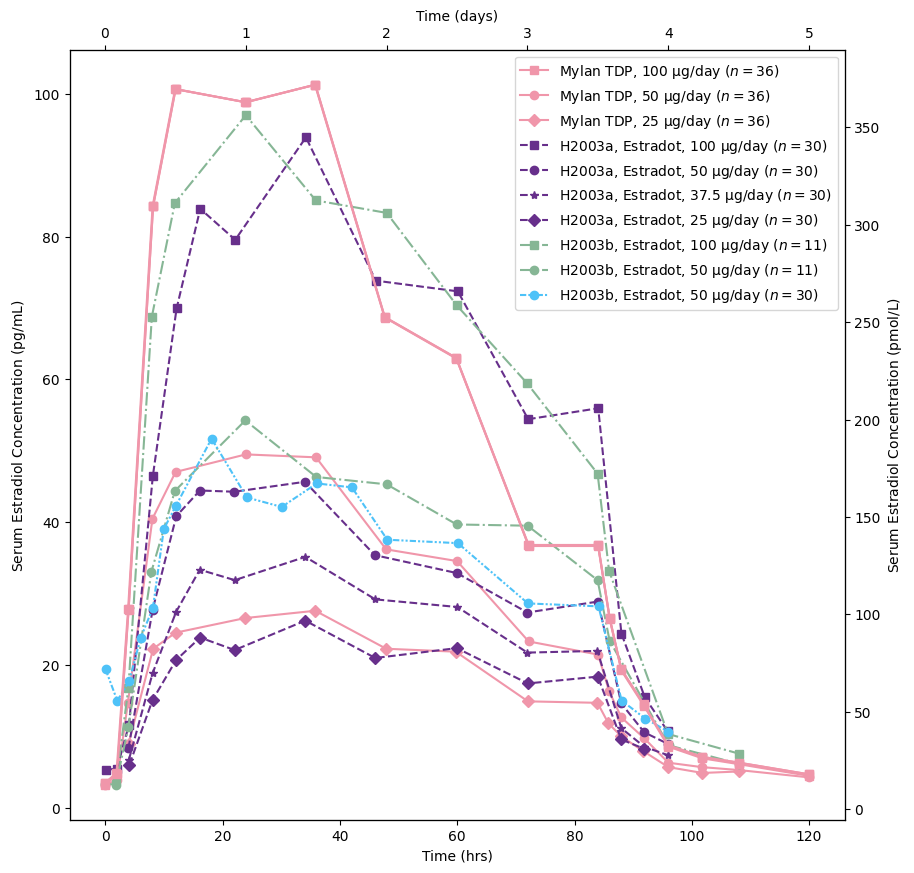

In [137]:
# plotting data obtained from literature

fig, ax1 = plt.subplots(figsize=(10,10))

# Mylan Estradiol TDP data
ax1.plot(MylanTDP100[:,0], MylanTDP100[:,1], color='#F096AA', marker='s', label="Mylan TDP, 100 $\\rm\\mu g$/day ($n=36$)")
ax1.plot(MylanTDP50[:,0], MylanTDP50[:,1], color='#F096AA', marker='o', label="Mylan TDP, 50 $\\rm\\mu g$/day ($n=36$)")
ax1.plot(MylanTDP25[:,0], MylanTDP25[:,1], color='#F096AA', marker='D', label="Mylan TDP, 25 $\\rm\\mu g$/day ($n=36$)")

# Hossain 2003a study, Estradot
ax1.plot(H2003aN30Estradot100[:,0], H2003aN30Estradot100[:,1], color='#672F8B', marker='s', linestyle='dashed', label="H2003a, Estradot, 100 $\\rm\\mu g$/day ($n=30$)")
ax1.plot(H2003aN30Estradot50[:,0], H2003aN30Estradot50[:,1], color='#672F8B', marker='o', linestyle='dashed', label="H2003a, Estradot, 50 $\\rm\\mu g$/day ($n=30$)")
ax1.plot(H2003aN30Estradot37_5[:,0], H2003aN30Estradot37_5[:,1], color='#672F8B', marker='*', linestyle='dashed', label="H2003a, Estradot, 37.5 $\\rm\\mu g$/day ($n=30$)")
ax1.plot(H2003aN30Estradot25[:,0], H2003aN30Estradot25[:,1], color='#672F8B', marker='D', linestyle='dashed', label="H2003a, Estradot, 25 $\\rm\\mu g$/day ($n=30$)")

# Hossain 2003b study, Estradot
ax1.plot(H2003bN11Estradot100[:,0], H2003bN11Estradot100[:,1], color='#86B695', marker='s', linestyle='dashdot', label="H2003b, Estradot, 100 $\\rm\\mu g$/day ($n=11$)")
ax1.plot(H2003bN11Estradot50[:,0], H2003bN11Estradot50[:,1], color='#86B695', marker='o', linestyle='dashdot', label="H2003b, Estradot, 50 $\\rm\\mu g$/day ($n=11$)")

# Hossain 2003b study, Estradot
ax1.plot(H2003bN30Estradot50[:,0], H2003bN30Estradot50[:,1], color='#4EC2F8', marker='o', linestyle=(0, (3, 1, 1, 1, 1, 1)), label="H2003b, Estradot, 50 $\\rm\\mu g$/day ($n=30$)")

ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Serum Estradiol Concentration ($\\rm pg/mL$)')
ax1.legend()

# 2nd y-axis in pmol/L rather than pg/mL
# https://transfemscience.org/misc/hormone-conc-unit-conv/
ax2 = ax1.twinx()
ax2.plot(MylanTDP100[:,0], MylanTDP100[:,1]*3.6713415, color='#F096AA', marker='s')
ax2.set_ylabel('Serum Estradiol Concentration ($\\rm pmol/L$)')

# 2nd x-axis in days rather than hrs
ax3 = ax1.twiny()
ax3.plot(MylanTDP100[:,0]/24, MylanTDP100[:,1], color='#F096AA', marker='s')
ax3.set_xlabel('Time (days)')

plt.show()

From the above plot, we can see the variability between estradiol patch brands exist. Of course, that could result from individual responses if we compare the study [H2003a](https://doi.org/10.1016/S0378-5122(03)00189-0) with [H2003b](https://doi.org/10.1016/S0378-5122(03)00190-7), in addition to two sample sizes within a single study [H2003b](https://doi.org/10.1016/S0378-5122(03)00190-7) at a dosage of $50\rm~\mu g/day$ ($n=11$ vs. $n=30$).

## Fitting the Literature Data

Next, we will fit the literature data to our model. We start with Mylan Estradiol TDP data, one fit for each dosage. Then moving on to Estradot studies, we will have one single fit for each dosage across different studies and sample sizes.

We have the solution to serum Estradiol concentration $E_2(t)$

\begin{align*}
    E_2(t) = &~k_1k_2D(t_0)\left[\frac{e^{-k_1t}}{(k_1-k_2)(k_1-k_3)} - \frac{e^{-k_2t}}{(k_1-k_2)(k_2-k_3)} + \frac{e^{-k_3t}}{(k_1-k_3)(k_2-k_3)}\right] \\
    &~+k_2A_{\rm eff}(t_0)\left[-\frac{e^{-k_2t}}{k_2-k_3} + \frac{e^{-k_3t}}{k_2-k_3}\right] + E_2(t_0)e^{-k_3t},
\end{align*}
where $A_{\rm eff}$ is a black box. We will leave the dosage units in mcg and leave the scaling to the fitting parameters.

In [182]:
# fitting function without A_{\rm eff}

def E2Dose(t, D0, k1, k2, k3):

    #Aeff0 = MylanTDP100[:,1][0]
    E20 = MylanTDP100[:,1][0]

    DoseDecay = np.exp(-k1 * t) / ((k1 - k2) * (k1 - k3))
    EffCompDecay = np.exp(-k2 * t) / ((k1 - k2) * (k2 - k3))
    E2Decay = np.exp(-k3 * t) / ((k1 - k3) * (k2 - k3))
    DoseOut = D0 * (DoseDecay - EffCompDecay + E2Decay)

    # compute A_{\rm eff} term and E_2(t_0) term

    #Aeff0Out = k2 * Aeff0 * (-np.exp(-k2 * t)/(k2 - k3) + np.exp(-k3 * t)/(k2 - k3))
    E20Out = E20 * np.exp(-k3 * t)

    return k1 * k2 * DoseOut + E20Out

In [183]:
# here, we guess the initial fitting parameters based on https://www.desmos.com/calculator/ohsy9gslkn
# see https://discord.com/channels/438306949285806082/438308040446574592/1197997367518048336

pMylan100, covMylan100 = curve_fit(E2Dose, MylanTDP100[:,0], MylanTDP100[:,1], 
                                   p0=[100,0.146,20.57,0.0826], maxfev=5000)
                                    # bounds=((0,0,0,0), (100,1e3,1e3,1e3))

In [184]:
# computing the fitted model for plotting
Mylan100Estimate = E2Dose(MylanTDP100[:,0], pMylan100[0], pMylan100[1], pMylan100[2], pMylan100[3])

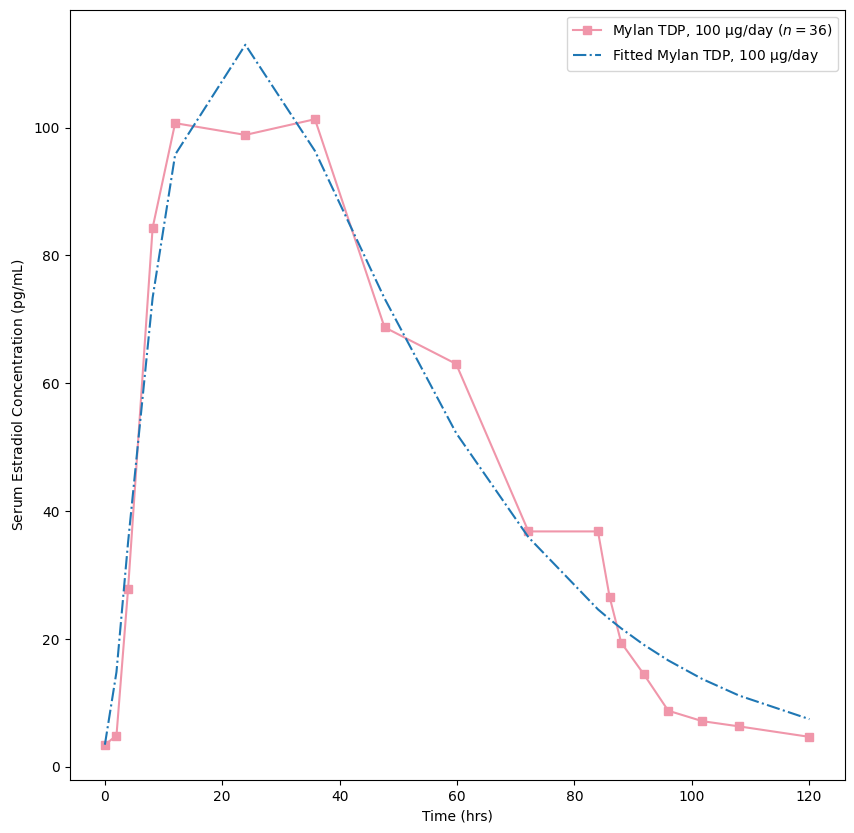

In [185]:
# plotting data obtained from literature

fig, ax1 = plt.subplots(figsize=(10,10))

# Mylan Estradiol TDP data
ax1.plot(MylanTDP100[:,0], MylanTDP100[:,1], color='#F096AA', marker='s', label="Mylan TDP, 100 $\\rm\\mu g$/day ($n=36$)")
ax1.plot(MylanTDP100[:,0], Mylan100Estimate, linestyle='dashdot', label="Fitted Mylan TDP, 100 $\\rm\\mu g$/day")


ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Serum Estradiol Concentration ($\\rm pg/mL$)')
ax1.legend()
plt.show()

In [186]:
# refining the model using lmfit, using fitted paramters from ...
# ... curve_fit as the initial guess

Mylan100Model = Model(E2Dose)
print(f'parameter names: {Mylan100Model.param_names}')
print(f'independent variables: {Mylan100Model.independent_vars}')

parameter names: ['D0', 'k1', 'k2', 'k3']
independent variables: ['t']


In [187]:
Mylan100Params = Mylan100Model.make_params(D0=100,k1=pMylan100[1],k2=pMylan100[2],k3=pMylan100[3])
Mylan100Model.set_param_hint('D0', vary=False)
Mylan100Fit = Mylan100Model.fit(MylanTDP100[:,1], Mylan100Params, t = MylanTDP100[:,0])

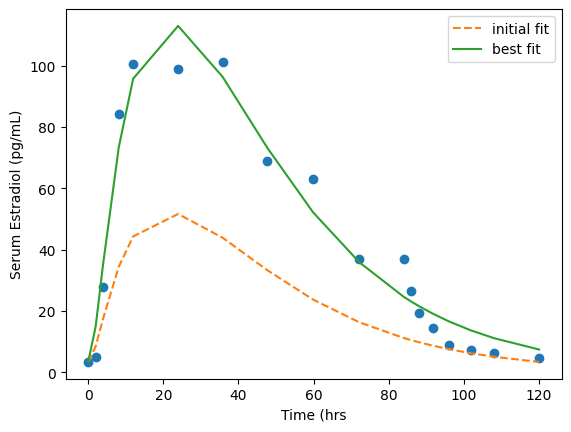

[[Model]]
    Model(E2Dose)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 18
    # variables        = 4
    chi-square         = 982.325624
    reduced chi-square = 70.1661160
    Akaike info crit   = 79.9919196
    Bayesian info crit = 83.5534066
    R-squared          = 0.95666068
[[Variables]]
    D0:  222.361032 +/- 59.6628028 (26.83%) (init = 100)
    k1:  0.07078994 +/- 0.03271300 (46.21%) (init = 0.07079167)
    k2:  0.57455868 +/- 0.41823955 (72.79%) (init = 0.5745717)
    k3:  0.03430977 +/- 0.00974889 (28.41%) (init = 0.03430907)
[[Correlations]] (unreported correlations are < 0.100)
    C(D0, k3) = +0.9869
    C(D0, k1) = -0.9555
    C(k1, k3) = -0.9480
    C(k1, k2) = -0.7940
    C(D0, k2) = +0.6402
    C(k2, k3) = +0.6307


/home/ubuntu/venv310/lib/python3.10/site-packages/lmfit/confidence.py:330: UserWarning: rel_change=-0.05244410950637564 < 1e-05 at iteration 2 and prob(D0=341.6866372922282) = 0.3438888420319795 < max(sigmas)
  warn(errmsg)


ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.

In [188]:
plt.plot(MylanTDP100[:,0], MylanTDP100[:,1], 'o')
plt.plot(MylanTDP100[:,0], Mylan100Fit.init_fit, '--', label='initial fit')
plt.plot(MylanTDP100[:,0], Mylan100Fit.best_fit, '-', label='best fit')
plt.xlabel('Time (hrs')
plt.ylabel('Serum Estradiol (pg/mL)')
plt.legend()
plt.show()

print(Mylan100Fit.fit_report())
print(Mylan100Fit.ci_report())

We are having trouble getting a good fit. To resolve this, we try to simplify our model to consists of two compartments only.

# Two-Compartment Model